# Interpolation: Air Quality Sensors

>* 👟 Ready To Run!
* 🖥️ Requires ArcPy
* 🖥️ Requires GeoEnrichment Portal Configuration
* 🔬 Data Science
* 🚀 Data Exploration and Cleaning
* 📈 Graphing and Visualization

![smokestacks](https://datasciencedemo.esri.com/dsx/notebooks/aabd3c6c47dd4720ab27da895d7a9c2f/files/home/anieto/AbandonedBaggyCoyote.gif)

The U.S. EPA AirNow program (www.AirNow.gov) protects public health by providing forecast and real-time observed air quality information across the United States, Canada, and Mexico. AirNow receives real-time air quality observations from over 2,000 monitoring stations and collects forecasts for more than 300 cities. 

In this notebook we will be exploring air quality monitoring station data to provide reports on air quality metrics for the nation. The purpose of this notebook is to provide an example of how to work with station point data, evaluate interpolation methods to produce a continuous air quality surface for use in maps and applications, and provide an information product to the public informing on the quality of the air for their area of interest. 

This notebook is produced by Esri in collaboration with the EPA's Office of Air Quality and Standards. 

**Outline of Steps**

 1. Connect to the [AirNow API](https://www.airnowapi.org) to retrieve current station data
 2. Explore and Clean the Data
    * Explore the data through tables and charts
    * Explore the data spatially
 3. Perform a spatial analysis of the data
    * Basic Interpolate Points
    * IDW Smooth
    * IDW Smooth Optimized
    * Kriging Default
    * Kriging Modified
    * Emipirical Bayesian Kriging
    * EBK Regression Prediction
 4. Create a small script to generate a daily interpolation with the selected method
 5. Generate a html report for daily scheduling

***

First, we need to import all the necessary libraries. These are also referred to as Python modules.

In [232]:
from arcgis.gis import GIS  # ArcGIS API for Python
from arcgis.features import GeoAccessor, GeoSeriesAccessor # Module functions to work with spatially-enablded dataframes
import pandas as pd         # Pandas is how we handle data in Python
import arcpy                # Access to ArcGIS Pro geoprocessing tools 
import numpy as np          # Access to python's scientific computing library
import scipy                # Modules for mathematics, science, and engineering
import os                   # Access to operating system commands
import requests             # Access to HTTPS commands to retrieve data
import getpass              # Access to secure handling of sensitive values (i.e. passwords, API keys)
from datetime import date, timedelta # Access to current date and time operations
from IPython.display import IFrame # Used to embed webpages for documentation and reference
from ipywidgets import *    # Access to utilities to use Jupyter Notebook widgets in neat ways 
import time                 # Time helper functions
import bokeh                # Access to charting tools
from bokeh.plotting import figure, show, output_file
from bokeh.io import output_notebook, output_file, show
from bokeh.models import Legend

In [233]:
# Set bokeh to output plots in the notebook
output_notebook()

Loading BokehJS ...

In [234]:
gis = GIS("home")           # Connect to the home GIS (ArcGIS Enterprise in which this notebook is running.)

In [235]:
# Set arcpy environment to overwrite outputs by default
arcpy.env.overwriteOutput = True

***

# 1. Get data using the AirNow API

In this section we will connect to the AirNow API to retrieve the latest air quality sensor data. From the API we will receive a table of air quality monitoring stations containing various measurements of air pollution. We need to convert this to a format that we can use in ArcGIS to interpolate and produce a continuous surface for use in maps and reports on the nation's air quality on any given day. This continuous surface is then shared as a service, which can be used by other applications and maps created by the public.

## Connect to the AirNow API

First, we need to connect to the AirNow API and build a request for the most current air quality monitoring station data. Let's explore the webpage to find documentation that can help.

In [236]:
IFrame('https://docs.airnowapi.org/aq101', width=1366, height=600)

We will retrieve station point data using a timestamp and an API key to authenticate. The following is an example AirNow REST Request: https://www.airnowapi.org/airnowsitedata_2019030104?API_KEY=E7481512-D56F-E511-A1314CE18CD4A2B0

In order to access your API Key, go to https://docs.airnowapi.org/ and request an account. 

> If you cannot access an API key, this notebook provides a sample dataset to work with. 

> If you do have an API key, we can query the latest available air quality monitoring station data. Let's get started.

Here, we'll determine the date string for the API request for yesterday's data.

In [237]:
yesterday = date.today() - timedelta(1)
date_string = yesterday.strftime('%Y%m%d')+"04"
print(date_string)

2019042404


Now let's pass our AirNow API key

In [238]:
api_key = getpass.getpass("AirNow API Key: ")

AirNow API Key: ········


And now... we have our AirNow API request built: 

In [239]:
url = "https://www.airnowapi.org/airnowsitedata_{0}?API_KEY={1}".format(date_string, api_key)

From this point, Python's Pandas library is our best friend to retrieve data and start working. Pandas has a "read_csv" function, and we can pass the AirNow request URL as the source of the csv. The result is a Pandas Dataframe, a powerful data format that we can work with. 

In [240]:
airnow_df = pd.read_csv(url)
airnow_df.head() # Using the .head() method prints the first five lines of the dataset

,AQSID,SiteName,Status,EPARegion,Latitude,Longitude,Elevation,GMTOffset,CountryCode,StateName,...,OZONE,OZONE_Unit,NO2,NO2_Unit,CO,CO_Unit,SO2,SO2_Unit,PM10,PM10_Unit
0,483951076,Franklin Oak Grove,Active,R6,31.168889,-96.481944,136.9,0.0,US,TX,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,080699991,Rocky Mtn NP Collocated,Active,R3,40.277800,-105.545300,2744.7,0.0,US,CO,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,530639995,Colbert-Greenbluff,Active,R10,47.808226,-117.343270,577.4,-8.0,US,WA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,530639997,Spokane-E Broadway Ave (US),Active,R10,47.663963,-117.257652,611.2,-8.0,US,WA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,530639996,Liberty Lake-E Valeyway (US),Inactive,R10,47.660568,-117.084503,650.3,-8.0,US,WA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [59]:
# Optional: Export the dataset to a csv on the local filespace
airnow_df.to_csv(r"/arcgis/home/anieto/workspace/airnow_testdata.csv")

# 2. Explore and Clean the Data

## Explore the data tabularly

Now that we have our data, let's take a look at a few data exploration tools in Pandas. First, let's take a look at the top ten records of the dataframe.

In [60]:
airnow_df.head(10)

,AQSID,SiteName,Status,EPARegion,Latitude,Longitude,Elevation,GMTOffset,CountryCode,StateName,...,OZONE,OZONE_Unit,NO2,NO2_Unit,CO,CO_Unit,SO2,SO2_Unit,PM10,PM10_Unit
0,483951076,Franklin Oak Grove,Active,R6,31.168889,-96.481944,136.9,0.0,US,TX,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,080699991,Rocky Mtn NP Collocated,Active,R3,40.277800,-105.545300,2744.7,0.0,US,CO,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,530639995,Colbert-Greenbluff,Active,R10,47.808226,-117.343270,577.4,-8.0,US,WA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,530639997,Spokane-E Broadway Ave (US),Active,R10,47.663963,-117.257652,611.2,-8.0,US,WA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,530639996,Liberty Lake-E Valeyway (US),Inactive,R10,47.660568,-117.084503,650.3,-8.0,US,WA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,120350004,Flagler County,Active,R4,29.489082,-81.276833,0.0,-5.0,US,FL,...,11.0,PPB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,240050009,Baltimore County Near Road,Active,R3,39.371679,-76.746814,132.7,-5.0,US,MD,...,NaN,NaN,26.0,PPB,NaN,NaN,NaN,NaN,NaN,NaN
7,360850114,Staten Island,Inactive,R2,40.631699,-74.156898,0.0,-5.0,US,NY,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,MMGBU1001,GBUAPCD EBAM @ Bridgeport,Inactive,R9,38.257656,-119.218483,0.0,-8.0,US,MM,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,360850111,Fresh Kills,Active,R2,40.580200,-74.199400,0.0,-5.0,US,NY,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [61]:
original_number_of_records = len(airnow_df)
print("There are {} records in the dataset originally from the API.".format(original_number_of_records))

There are 2816 records in the dataset originally from the API.


Now let's explore the columns and their data types

In [62]:
airnow_df.dtypes

AQSID                           object
SiteName                        object
Status                          object
EPARegion                       object
Latitude                       float64
Longitude                      float64
Elevation                      float64
GMTOffset                      float64
CountryCode                     object
StateName                       object
ValidDate                       object
ValidTime                       object
DataSource                      object
ReportingArea_PipeDelimited     object
OZONE_AQI                      float64
PM10_AQI                       float64
PM25_AQI                       float64
NO2_AQI                        float64
OZONE_Measured                   int64
PM10_Measured                    int64
PM25_Measured                    int64
NO2_Measured                     int64
PM25                           float64
PM25_Unit                       object
OZONE                          float64
OZONE_Unit               

One of the columns, 'PM25_AQI', refers to particulate matter, a form of air pollution. Let's explore the distribution of values in this column using a simple chart, invoked via Pandas's built-in .plot() method.

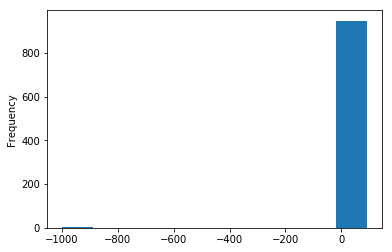

In [63]:
airnow_df['PM25_AQI'].plot(kind='hist')

Unfortunately, this chart looks off... There's some stations that register with a _very_ negative value. Let's take a look at some summary statistics for this field.

In [64]:
airnow_df['PM25_AQI'].describe()

count    952.000000
mean      19.280462
std       75.162258
min     -999.000000
25%       15.000000
50%       23.000000
75%       31.000000
max       91.000000
Name: PM25_AQI, dtype: float64

There's the culprit: stations with missing data have been coded as -999. Let's query these records out. 

### Clean PM25_AQI Data

In [65]:
print("Pre-query record count: {0}".format(airnow_df.shape[0]))
airnow_df = airnow_df.query("PM25_AQI > -999")
print("Post-query record count: {0}".format(airnow_df.shape[0]))

Pre-query record count: 2816
Post-query record count: 947


In [66]:
airnow_df = airnow_df.query("PM25_AQI > -999")

Re-executing the code that created the PM25_AQI chart now gives us a much cleaner distribution of values that we can work with. 

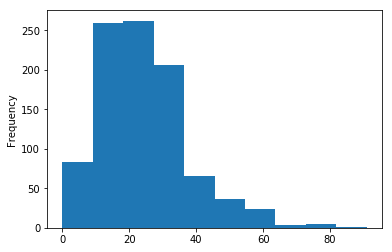

In [67]:
airnow_df['PM25_AQI'].plot(kind='hist')

Using a python library called Bokeh, we can make a nicer chart

In [68]:
hist, edges = np.histogram(airnow_df['PM25_AQI'])

p = figure()
p.quad(top=hist, bottom=0, left=edges[:-1], right=edges[1:], line_color="white")

# output_file("hist.html")
show(p)

## Explore the data spatially

We need to convert our Pandas dataframe into a Spatially-Enabled Dataframe (SEDF). This allows us to quickly work with spatial analysis tools and more easily visualize the information on a map. 

The Spatially Enabled DataFrame (SeDF) inserts a custom namespace called spatial into the popular Pandas DataFrame structure to give it spatial abilities. Once you have two fields for latitude and longitude respectively, you can convert a Pandas DataFrame to a SeDF. Besides, you can also create SeDF from many other sources, including GeoJSON, feature classes, shapefiles, feature layers, and feature services, etc.

SeDF is based on data structures inherently suited to data analysis, with natural operations for the filtering and inspecting of subsets of values which are fundamental to statistical and geographic manipulations. For more information about SeDF, please refer to: https://developers.arcgis.com/python/guide/introduction-to-the-spatially-enabled-dataframe/

In [69]:
airnow_sdf = pd.DataFrame.spatial.from_xy(df=airnow_df, x_column="Longitude", y_column="Latitude", sr=4326)
airnow_sdf.head()

,AQSID,SiteName,Status,EPARegion,Latitude,Longitude,Elevation,GMTOffset,CountryCode,StateName,...,OZONE_Unit,NO2,NO2_Unit,CO,CO_Unit,SO2,SO2_Unit,PM10,PM10_Unit,SHAPE
2,530639995,Colbert-Greenbluff,Active,R10,47.808226,-117.343270,577.4,-8.0,US,WA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{""x"": -117.34326999999999, ""y"": 47.808226, ""sp..."
3,530639997,Spokane-E Broadway Ave (US),Active,R10,47.663963,-117.257652,611.2,-8.0,US,WA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{""x"": -117.25765200000001, ""y"": 47.663963, ""sp..."
10,390610048,Cincinnati Near Road,Active,R5,39.146025,-84.538375,0.0,-5.0,US,OH,...,NaN,NaN,NaN,0.63,PPM,NaN,NaN,NaN,NaN,"{""x"": -84.538375, ""y"": 39.146025, ""spatialRefe..."
14,390610040,Taft,Active,R5,39.128860,-84.504040,0.0,-5.0,US,OH,...,PPB,8.0,PPB,0.14,PPM,1.0,PPB,22.0,UG/M3,"{""x"": -84.50404, ""y"": 39.128859999999996, ""spa..."
16,390990014,Youngstown - Head Start,Active,R5,41.095938,-80.658467,0.0,-5.0,US,OH,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{""x"": -80.658467, ""y"": 41.095938000000004, ""sp..."


We will first focus only on PM25_AQI measurements of air quality. Following this sequence, we can integrate other metrics. Let's remove unnecessary columns for this first run.

First, let's establish a list of baseline columns that every run of this notebook will need. 

In [73]:
baseline_columns = ["AQSID", "SiteName", "Status", "EPARegion", "Latitude", "Longitude", "Elevation", "GMTOffset", "CountryCode", "StateName", "ValidDate", "ValidTime", "SHAPE"]

Then, let's specify the air quality analysis field for the interpolation sequence

In [74]:
analysis_column = ["PM25_AQI"]

Now we can create our final columns list and create a subset SeDF

In [75]:
airnow_pm25aqi_sdf = airnow_sdf[baseline_columns + analysis_column]
airnow_pm25aqi_sdf.head()

,AQSID,SiteName,Status,EPARegion,Latitude,Longitude,Elevation,GMTOffset,CountryCode,StateName,ValidDate,ValidTime,SHAPE,PM25_AQI
2,530639995,Colbert-Greenbluff,Active,R10,47.808226,-117.343270,577.4,-8.0,US,WA,04/23/19,04:00,"{""x"": -117.34326999999999, ""y"": 47.808226, ""sp...",22.0
3,530639997,Spokane-E Broadway Ave (US),Active,R10,47.663963,-117.257652,611.2,-8.0,US,WA,04/23/19,04:00,"{""x"": -117.25765200000001, ""y"": 47.663963, ""sp...",18.0
10,390610048,Cincinnati Near Road,Active,R5,39.146025,-84.538375,0.0,-5.0,US,OH,04/23/19,04:00,"{""x"": -84.538375, ""y"": 39.146025, ""spatialRefe...",39.0
14,390610040,Taft,Active,R5,39.128860,-84.504040,0.0,-5.0,US,OH,04/23/19,04:00,"{""x"": -84.50404, ""y"": 39.128859999999996, ""spa...",29.0
16,390990014,Youngstown - Head Start,Active,R5,41.095938,-80.658467,0.0,-5.0,US,OH,04/23/19,04:00,"{""x"": -80.658467, ""y"": 41.095938000000004, ""sp...",35.0


Now let's create a map using the ArcGIS API for Python and visualize the SeDF locations

In [96]:
stations_map = gis.map("USA", zoomlevel=4)
stations_map

MapView(layout=Layout(height='400px', width='100%'), zoom=4.0)

In [97]:
airnow_pm25aqi_sdf.spatial.plot(map_widget=stations_map)

/opt/conda/lib/python3.6/site-packages/arcgis/features/geo/_accessor.py:2161: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._data['OBJECTID'] = list(range(1, self._data.shape[0] + 1))


True

We can also make a map of graduaded circles or colors based on column values. 

For help with visualizing Spatially-enabled Dataframes, refer to the following link: https://developers.arcgis.com/python/guide/visualizing-data-with-the-spatially-enabled-dataframe/

In [98]:
airnow_pm25aqi_sdf.spatial.plot(map_widget=stations_map, renderer_type='c', method='esriClassifyNaturalBreaks', class_count=5, col="PM25_AQI", cmap='Oranges')

True

To know more about Visualizing Spatial Data through sedf, see https://developers.arcgis.com/python/guide/visualizing-data-with-the-spatially-enabled-dataframe/

## Clean data spatially

Notice on the map that one of the stations is located in Manama, Bahrain. While it's interesting that AirNow includes an air monitoring station in the Middle East and South America, it's not terribly useful for our USA interpolation purposes, so let's do a basic operation to remove data outside of North America. 

As GIS analysts and data scientists, we also want to query based on geographic location. We can do that by building a spatial index with the sindex property of the spatial dataframe. The resulting quadtree index allows us to query based on specific geometries in relation to other geometries.

We can draw the entire extent of our dataframe using the dataframe's geoextent property. Let's get the bounding box coordinates and display the extent of our data on a map:

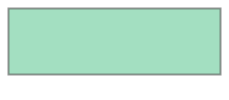

In [134]:
df_geoextent_geom = airnow_pm25aqi_sdf.spatial.bbox
df_geoextent_geom

In [135]:
extent_map = gis.map("USA", 3)
extent_map.draw(df_geoextent_geom)
extent_map

MapView(layout=Layout(height='400px', width='100%'), zoom=3.0)

Now, let's define a second set of coordinates representing a bounding box for which we want to query the features from our dataframe that fall within it. We care about stations in North America (for now), so let's find a layer of data containing data just from North America to use its geometry. 

The Living Atlas contains a "North America Hexbins 25km" layer that nicely helps us get this geometry:

<Item title:"North America Hexbins 25km" type:Feature Layer Collection owner:esri_livingatlas>
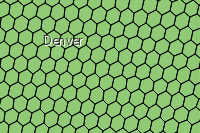

In [120]:
# Item Added From Toolbar
# Title: North America Hexbins 25km | Type: Feature Service | Owner: esri_livingatlas
northamerica_item = gis.content.get("90653a3ca0e346afb76c171909278696")
northamerica_item

#### TODO: Filter features by extent of North America Hexbins

## Create Feature Layer and Feature Class Versions of the Data for Analysis

Now that we've explored and cleaned the data tabularly and spatially, we're ready to start our interpolations. Let's prepare the data in a few formats so that we can test a variety of tools. We'll need the following formats: 
> Hosted Feature Layer

> Feature Class

Thankfully, the Spatially-enabled Dataframe contains a few helper functions to convert to the needed formats. 

The first one we'll use is .spatial.to_featurelayer:

In [136]:
airnow_fl = airnow_sdf.spatial.to_featurelayer(f"AirNow_{date_string}", gis=gis, tags="AirNow")
airnow_fl

<Item title:"AirNow_2019042304" type:Feature Layer Collection owner:anieto>

The second one we'll use is .spatial.to_featureclass, but first we'll need to create a file geodatabase on local file-space. 

In [140]:
if arcpy.Exists(r"/arcgis/home/anieto/workspace/AirNow.gdb"):
    print("Using existing file geodatabase...")
    airnow_fgdb = r"/arcgis/home/anieto/workspace/AirNow.gdb"
    
else:    
    print("Creating new file geodatabase...")
    airnow_fgdb = arcpy.CreateFileGDB_management(r"/arcgis/home/anieto/workspace", "AirNow").getOutput(0)

Using existing file geodatabase...


In [141]:
airnow_fc = airnow_sdf.spatial.to_featureclass(location=os.path.join(airnow_fgdb, "AirNow_Test"))
airnow_fc

'/arcgis/home/anieto/workspace/AirNow.gdb/AirNow_Test'

Now we're ready to start our interpolation tests.

# 3. Perform a spatial analysis of the data

The goal of this notebook is to create continuous surfaces that help us provide information to the public on air quality at their location. Since data is monitored at specific locations, we'll need to estimate air quality values in locations where stations are not recording measurements. This is referred to as Interpolation, and there are a variety of methods to perform interpolation. 

In this notebook, we'll explore and compare a few different approaches. Once we determine an appropriate approach, we can then script the sequence to retrieve data, clean the data, interpolate, and publish the output services. 

## Basic interpolation

The first form of interpolation we'll test is the use of the "Interpolate Points" tool in ArcGIS Online / ArcGIS Enterprise.

In [144]:
IFrame("https://doc.arcgis.com/en/arcgis-online/analyze/interpolate-points.htm", width=1366, height=600)

To get started with _Interpolate Points_, let's create a map of our stations, then use the "Analysis" GUI option at the top (or navigate the ArcGIS API for Python) to run the tool.

MapView(layout=Layout(height='400px', width='100%'), zoom=4.0)


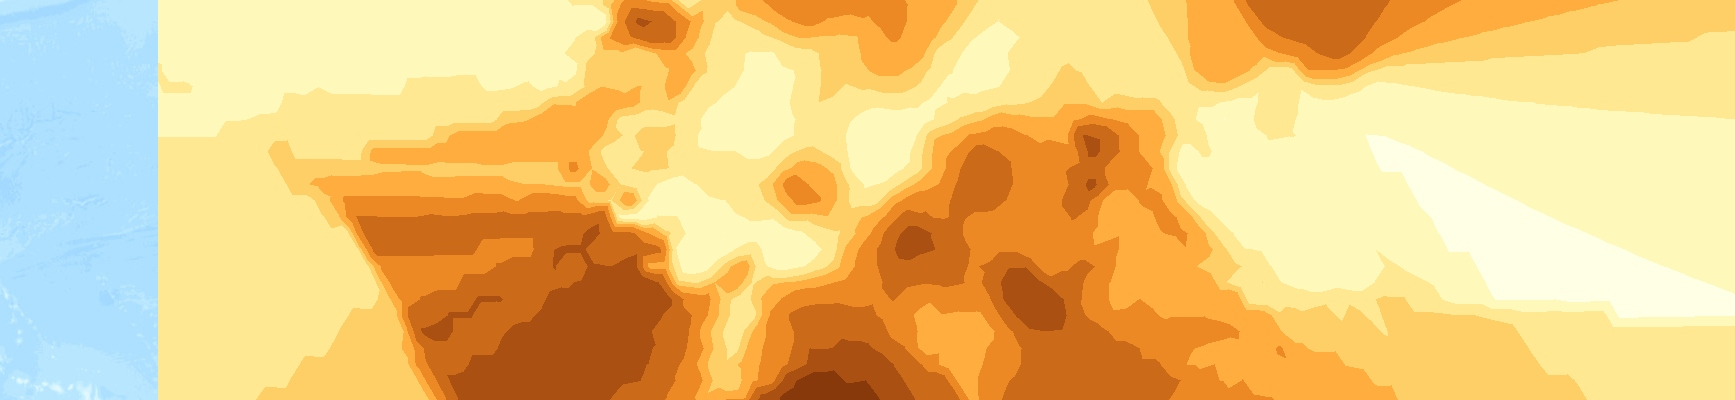

In [175]:
airnow_map = gis.map("usa", zoomlevel=4)
airnow_map.add_layer(airnow_fl)
airnow_map

In [145]:
# Added from the GUI
from arcgis import features
inter = features.analyze_patterns.interpolate_points(airnow_fl, "PM25_AQI")
inter

{'result_layer': <FeatureCollection>,
 'prediction_error': <FeatureCollection>,
 'predicted_point_layer': <FeatureCollection>}

In [158]:
inter['result_layer']

<FeatureCollection>

In [169]:
# Add the resulting layer to the map
airnow_map.add_layer(inter['result_layer'])


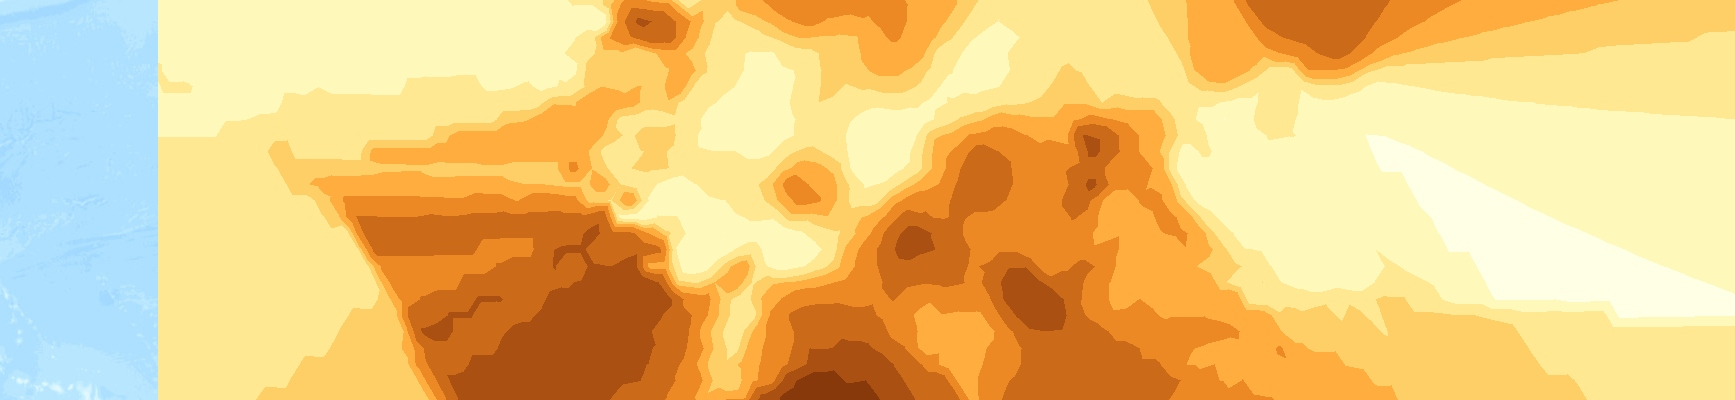

In [177]:
# Take a screenshot of the rough-looking map
airnow_map.take_screenshot()

The interpolation map looks rough! People (generally) don't live in the open sea, so we're not immediately conconcerned with a surface that shows the interpolated values beyond the continental United States. To correct this, we'll use the _Interpolate Points_ tool's "bounding_polygon_layer" parameter, passing it a boundary layer for the United States. 

<Item title:"USA States (Generalized)" type:Feature Layer Collection owner:esri_livingatlas>
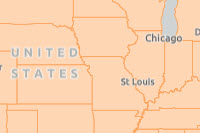

In [178]:
# Item Added From Toolbar
# Title: USA States (Generalized) | Type: Feature Service | Owner: esri_livingatlas
states = gis.content.get("99fd67933e754a1181cc755146be21ca")
states

In [180]:
from arcgis import features
new_inter = features.analyze_patterns.interpolate_points(airnow_fl, "PM25_AQI", bounding_polygon_layer=states)
new_inter

{'result_layer': <FeatureCollection>,
 'prediction_error': <FeatureCollection>,
 'predicted_point_layer': <FeatureCollection>}

In [195]:
airnow_basicinter_map = gis.map("usa", zoomlevel=4)
airnow_basicinter_map

MapView(layout=Layout(height='400px', width='100%'), zoom=4.0)

In [197]:
airnow_basicinter_map.add_layer(new_inter['result_layer'], {'opacity':0.75})
airnow_basicinter_map.legend = True

The _Interpolate Points_ tool also has configurable options to favor speed or accuracy. The following table expresses what each option actually does.

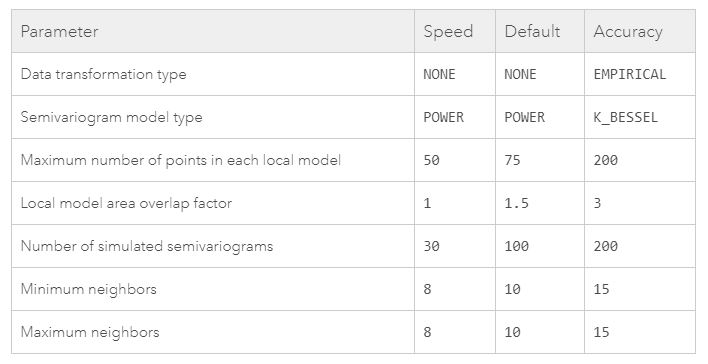

Let's test out interpolation for each option and evaluate results. Reference documentation can be found here: https://esri.github.io/arcgis-python-api/apidoc/html/arcgis.features.analyze_patterns.html#interpolate-points

In [228]:
start = time.clock()
inter_speed = features.analyze_patterns.interpolate_points(airnow_fl, "PM25_AQI", bounding_polygon_layer=states, interpolate_option=1, output_prediction_error=True)
print(f"Speed option time: {time.clock() - start}")

start = time.clock()
inter_medium = features.analyze_patterns.interpolate_points(airnow_fl, "PM25_AQI", bounding_polygon_layer=states, interpolate_option=5, output_prediction_error=True)
print(f"Medium option time: {time.clock() - start}")
      
start = time.clock()
inter_accuracy = features.analyze_patterns.interpolate_points(airnow_fl, "PM25_AQI", bounding_polygon_layer=states, interpolate_option=9, output_prediction_error=True)
print(f"Accuracy option time: {time.clock() - start}")

Speed option time: 0.03926199999999369
Medium option time: 0.03707099999999741
Accuracy option time: 0.05480200000000224


In [229]:
inter_speed_map = gis.map("USA", 3)
inter_speed_map.add_layer(inter_speed['result_layer'])
inter_medium_map = gis.map("USA", 3)
inter_medium_map.add_layer(inter_medium['result_layer'])
inter_accuracy_map = gis.map("USA", 3)
inter_accuracy_map.add_layer(inter_accuracy['result_layer'])

box = HBox([inter_speed_map, inter_medium_map, inter_accuracy_map])
box

According to the tool documentation:

_A layer of standard errors can be created by checking the Output prediction errors box. A 95 percent confidence interval can be calculated for the interpolated layer by taking the interpolation value and adding two standard errors for the upper limit and subtracting two standard errors from the lower limit._

Let's load these standard error layers for each interpolation approach.

In [231]:
inter_speed_map = gis.map("USA", 3)
inter_speed_map.add_layer(inter_speed['prediction_error'])
inter_medium_map = gis.map("USA", 3)
inter_medium_map.add_layer(inter_medium['prediction_error'])
inter_accuracy_map = gis.map("USA", 3)
inter_accuracy_map.add_layer(inter_accuracy['prediction_error'])

box = HBox([inter_speed_map, inter_medium_map, inter_accuracy_map])
box

## ArcPy Interpolation - EBK Regression Prediction; Forest-based Classification and Regression

Placeholder description